In [1]:
%pwd

'/Users/costefan/UCU/3 sem/CV/cv_1/hw1'

In [2]:
from matplotlib import pyplot as plt

Bad val 'TkAggX' on line #1
	"backend: TkAggX
"
	in file "/Users/costefan/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string 'tkaggx': valid strings are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [3]:
def show_img(img, cmap):
    plt.imshow(img, cmap)

In [4]:
# %load taks1.py
import cv2
import numpy as np
from scipy.signal import convolve2d


def read_img(img_path='./res/marker_cut_gray_42.png'):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray


def edge_detection(img):
    """
    Edge detection using Sobel
    operator
    :param img: 
    :return: 
    """
    G_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ])
    G_y = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1],
    ])
    img_g_x = convolve2d(img, G_x)
    img_g_y = convolve2d(img, G_y)

    return np.sqrt(img_g_x ** 2 + img_g_y ** 2)

In [6]:
img = read_img('images/marker_cut_rgb_512.png')

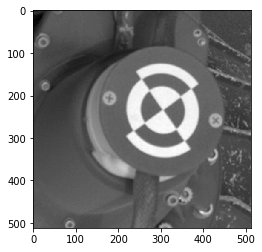

In [7]:
show_img(img, 'gray')

In [11]:
from utils.gaussian_blur import gaussian_blur
img = gaussian_blur(img, (3, 3), 0.9)

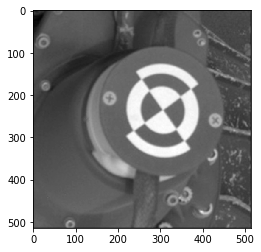

In [12]:
show_img(img, cmap='gray')

In [13]:
edges = edge_detection(img)
edges = edges.astype('uint8')

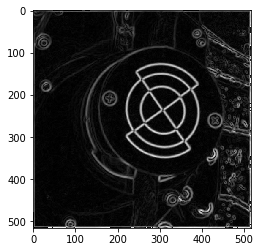

In [14]:
show_img(edges, cmap='gray')

In [21]:
ret, edges = cv2.threshold(edges, 150, 255, cv2.THRESH_BINARY)

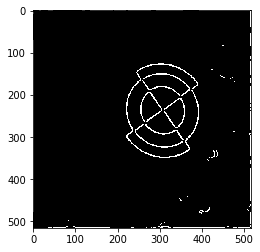

In [22]:
show_img(edges > 150, cmap='gray')

In [26]:
# %load hough/task_1_homework_solution.py
import cv2
import os
import numpy as np
from scipy.signal import convolve2d

from utils.gaussian_blur import gaussian_blur

import hough.common as common

DEBUG = True

# Tunable constants
DEG_STEP = 1
N_LARGEST = 10
EDGE_THRESHOLD = 100


IMG_DIR_PATH = os.path.join(os.path.dirname(''), 'output')


def k_largest_index_argsort(a, k):
    """Finding largest values indexes in 2d numpy array
    :param a: 
    :param k: 
    :return: 
    """
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))


def read_img(img_path='./res/marker_cut_gray_42.png'):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray


def show_img(image):
    cv2.imshow('img', image)
    cv2.waitKey()


def edge_detection(img):
    """
    Edge detection using Sobel
    operator
    :param img: 
    :return: 
    """
    G_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1],
    ])
    G_y = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1],
    ])
    # if it was required not to use convolve2d,
    #  task2 has convolution_2d implemented
    img_g_x = convolve2d(img, G_x)
    img_g_y = convolve2d(img, G_y)

    return np.sqrt(img_g_x ** 2 + img_g_y ** 2)


def hough_transform(img, deg_step=DEG_STEP):
    """Hough transform
    :param img: 
    :param deg_step: 
    :return: 
    """
    # brootforce vals
    thetas = np.deg2rad(np.arange(-90.0, 90.0, deg_step))
    r_length = int(round(np.sqrt(img.shape[0] ** 2 +
                                 img.shape[1] ** 2)))
    rhos = np.arange(-r_length, r_length, 1)

    thetas_count = len(thetas)
    hough_acc = np.zeros((2 * r_length, thetas_count))

    for y, x in zip(*np.nonzero(img)):
        for t_ix, theta in enumerate(thetas):
            rho = int(round(x * np.cos(theta) + y * np.sin(theta))) + r_length
            hough_acc[rho][t_ix] += 1

    return hough_acc, thetas, rhos


def main(input_fname, output_fname):
    """
    Main function
    Steps:
    read_image
    gaussian blur
    edge_detection
    threshold on edges image
    hough transform
    hough space points detection
    output results
    
    :param input_fname: 
    :param output_fname: 
    :return: 
    """
    img = read_img(input_fname)
    img = gaussian_blur(img, (3, 3), 0.9)

    cv2.imwrite(IMG_DIR_PATH + '/after_blur.png', img)

    edges = edge_detection(img).astype('uint8')

    cv2.imwrite(IMG_DIR_PATH + '/after_edge_det.png', edges)

    ret, edges = cv2.threshold(edges, EDGE_THRESHOLD, 255, cv2.THRESH_BINARY)

    cv2.imwrite(IMG_DIR_PATH + '/after_threshold.png', edges)

    hough_acc, thetas, rhos = hough_transform(edges)
    # founding n maximum
    if DEBUG:
        print(k_largest_index_argsort(hough_acc, N_LARGEST))
        print(hough_acc.shape)

    rhos_max, thetas_max = [], []
    for rh_ix, t_ix in k_largest_index_argsort(hough_acc, N_LARGEST):
        rhos_max.append(rhos[rh_ix])
        thetas_max.append(thetas[t_ix])

    img = common.draw_lines_on_img([zip(rhos_max, thetas_max)], img)

    cv2.imwrite(output_fname, img)

In [27]:
hough_acc, thetas, rhos = hough_transform(edges)

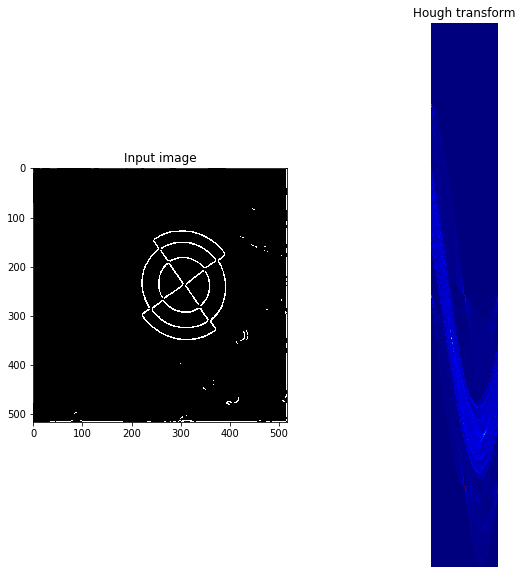

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(edges, cmap='gray')
ax[0].set_title('Input image')
ax[0].axis('image')

ax[1].imshow(
    hough_acc, cmap='jet',
    extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

plt.axis('off')
plt.show()

In [34]:
rhos_max, thetas_max = [], []
for rh_ix, t_ix in k_largest_index_argsort(hough_acc, N_LARGEST):
    rhos_max.append(rhos[rh_ix])
    thetas_max.append(thetas[t_ix])

In [37]:
print(rhos_max)
print(thetas_max)

[513, 2, 1, 514, -2, -1, -513, -514, 116, 371]
[0.0, 0.0, 0.0, 0.0, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -1.5707963267948966, -0.6108652381980153, 0.9424777960769379]


In [38]:
import hough.common as common
img = common.draw_lines_on_img([zip(rhos_max, thetas_max)], img)

(513, 1000) (513, -1000)
(2, 1000) (2, -1000)
(1, 1000) (1, -1000)
(514, 1000) (514, -1000)
(1000, 2) (-1000, 1)
(1000, 1) (-1000, 0)
(1000, 513) (-1000, 512)
(1000, 514) (-1000, 513)
(668, 752) (-478, -885)
(-590, 887) (1027, -287)


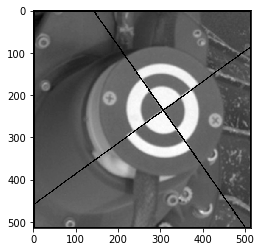

In [40]:
plt.imshow(img, 'gray')